In [12]:
from qiskit import BasicAer

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType 
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
import numpy as np
import pylab

In [6]:
driver = PySCFDriver(atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0',
                     unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print('Hartree-Fock energy: {}'.format(molecule.hf_energy))
print('Nuclear repulsion energy: {}'.format(molecule.nuclear_repulsion_energy))
print('Number of molecular orbitals: {}'.format(molecule.num_orbitals))
print('Number of alpha electrons: {}'.format(molecule.num_alpha))
print('Number of beta electrons: {}'.format(molecule.num_beta))

Hartree-Fock energy: -74.9629466565383
Nuclear repulsion energy: 9.193913160623385
Number of molecular orbitals: 7
Number of alpha electrons: 5
Number of beta electrons: 5


In [9]:
core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=True, freeze_core=True)
qubit_op, aux_ops = core.run(molecule)

print(qubit_op)

Representation: paulis, qubits: 10, size: 551


In [14]:
h2o = 'H; O 1 1.08; H 2 {} 1 104.5'

distances = [x * 0.01 + 1.00 for x in range(17)]
energies = np.empty(len(distances))

for i, distance in enumerate(distances):
    print(i)
    driver = PySCFDriver(h2o.format(distance), basis='sto3g')
    qmolecule = driver.run()
    core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                           two_qubit_reduction=True, freeze_core=True)
    qubit_op, aux_ops = core.run(qmolecule)
    #optimizer = SLSQP(maxiter=2500)
    
    init_state = HartreeFock(num_qubits=qubit_op.num_qubits, 
                         num_orbitals=core._molecule_info['num_orbitals'],
                         num_particles=core._molecule_info['num_particles'],
                         qubit_mapping=core._qubit_mapping,
                         two_qubit_reduction=core._two_qubit_reduction)

    var_form = UCCSD(num_qubits=qubit_op.num_qubits,
                 depth=1,
                 num_orbitals=core._molecule_info['num_orbitals'], 
                 num_particles=core._molecule_info['num_particles'],
                 qubit_mapping=core._qubit_mapping,
                 two_qubit_reduction=core._two_qubit_reduction, 
                 initial_state=init_state)
    optimizer = SLSQP(maxiter=2500)
    
    backend = BasicAer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend=backend)
    vqe = VQE(qubit_op, var_form, optimizer)
    algo_result = vqe.run(quantum_instance)
    lines, result = core.process_algorithm_result(algo_result)
    
    energies[i] = result['energy']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


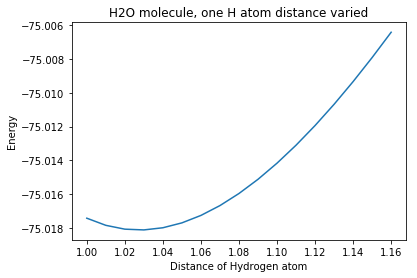

In [17]:
pylab.plot(distances, energies)
pylab.xlabel('Distance of Hydrogen atom')
pylab.ylabel('Energy')
pylab.title('H2O molecule, one H atom distance varied');